## **Task I: Electron/Photon Classification**
**Datasets**:

https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (photons)

https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (electrons)

**Description**: 32x32 matrices with two channels: hit energy and time for two types of
particles, electrons and photons, hitting the detector.

Please use a **Resnet-15 (you are free to play around with the architecture) like model**, to achieve the highest possible
classification score on this image dataset. Please provide a **Jupyter notebook** that shows your solution along with the model weights. Preferably only use **PyTorch** or Keras in your solutions.

Please train your model on 80% of the data and evaluate on the remaining 20%. Please make sure not to overfit on the test dataset - it will be checked with an independent sample.

In [1]:
# Default libraries
import sys
import warnings

# Data preprocessing & visualization
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Deep learning
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Helper functions & models
sys.path.append('../')
from utils import train_and_validate, accuracy_metric_ce, plot_history, test
from models import ParallelResNet15

# Settings
warnings.filterwarnings('ignore')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### **1. Data Preprocessing**

In [2]:
# Load the data
data_dir = '../data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

# Function to load the data from the HDF5 files
def load_hdf5_data(decays: list[str], start: int, stop: int) -> tuple[np.ndarray, np.ndarray]:
    datasets = [h5py.File('%s/%s.hdf5'%(data_dir, decay)) for decay in decays]
    X = np.concatenate([dataset['/X'][start:stop] for dataset in datasets], axis=0)
    y = np.concatenate([dataset['/y'][start:stop] for dataset in datasets], axis=0)
    assert len(X) == len(y)
    return X, y

# Get the size of the dataset
# X, y = load_data(decays, start=0, stop=None)
# print(X.shape, y.shape)  # (498000, 32, 32, 2) (498000,)

# Train, validation, and test sets ratio
num_samples = 249_000
train_size = int(0.7 * num_samples)
valid_size = int(0.1 * num_samples)
test_size = int(0.2 * num_samples)

In [3]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
X_train, y_train = load_hdf5_data(decays, train_start, train_stop)

# Set range of validation set
valid_start, valid_stop = train_stop, train_stop + valid_size
assert valid_stop > valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_hdf5_data(decays, valid_start, valid_stop)

# Set range of test set
test_start, test_stop = valid_stop, valid_stop + test_size
assert test_stop > test_start
assert test_start >= valid_stop
X_test, y_test = load_hdf5_data(decays, test_start, test_stop)

# Check the number of samples
samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

# Permute the indices for PyTorch format
X_train = np.moveaxis(X_train, 3, 1)
X_valid = np.moveaxis(X_valid, 3, 1)
X_test = np.moveaxis(X_test, 3, 1)

# Check the shape
print(X_train.shape, X_valid.shape)

(348600, 2, 32, 32) (49800, 2, 32, 32)


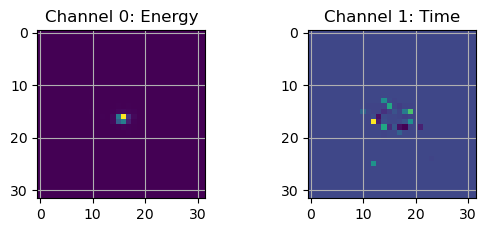

In [4]:
# Visualize a sample of the data
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,0,:,:])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,1,:,:])
plt.title("Channel 1: Time")  # Time
plt.grid(True)

plt.show()

In [ ]:
# Construct the dataset and dataloader
class ClassificationDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = torch.from_numpy(y.copy()).long()
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]

        if self.transform:
            x = self.transform(x)
        else:
            x = torch.from_numpy(x.copy()).float()
            
        return x, self.y[idx]
    
transform = transforms.Lambda(lambda x: torch.from_numpy(x).float())

# Datasets and dataloaders
train_dataset = ClassificationDataset(X_train, y_train, transform=transform)
valid_dataset = ClassificationDataset(X_valid, y_valid, transform=transform)
test_dataset = ClassificationDataset(X_test, y_test, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### **2. Parallel ResNet-15**

In [6]:
# Initialize the model
parallel_resnet15 = ParallelResNet15(num_classes=2, inplanes=64, planes=64, layers=[2, 2, 3]).to(device)
parallel_resnet15

ParallelResNet15(
  (resnet_energy): ResNet15(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

**Model Choice**:

- The ResNet-15 model and the parallel architecture are inspired from the paper below where the author placed 3 ResNet-15 models for separated barrel and endcap inputs. The final layer of his ResNet-15 is a global maxpooling layer, where he later flattened it and connected to a linear layer before the classifier.
- Here, I changed it a little bit by adding `nn.Linear` after `AdaptiveMaxPool2d`, then concatentate the 2 linear layers instead. I also increased the layers' size (from `[16, 32, 32]` like the original version to `[64, 128, 256]`) and instead of doing `[3, 1, 3]` BasicBlocks like the paper, I did `[2, 2, 3]`, which should also add up to 15.

**Citation**:

Andrews, M., Paulini, M., Gleyzer, S., & Poczos, B. (2020). [End-to-end physics event classification with CMS open data: Applying image-based deep learning to detector data for the direct classification of collision events at the LHC](https://arxiv.org/abs/1807.11916). *Computing and Software for Big Science*, 4, 1-14.

In [7]:
# Model hyperparameters
lr_init = 1e-3
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parallel_resnet15.parameters(), lr=lr_init, eps=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
save_path = '../model-checkpoints/Task1_parallel_resnet15.pt'

In [8]:
# Train the model
history, parallel_resnet15 = train_and_validate(
    model=parallel_resnet15,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    metric=accuracy_metric_ce,
    scheduler=scheduler,
    num_epochs=num_epochs,
    sep_channels=True,
    save_path=save_path,
    save_strategy='val_loss'  # save the epoch with best val loss, can be 'val_loss' or 'val_acc'
)

Epoch [1/30], Train Loss: 0.5963, Train Metric: 0.6918, Val Loss: 0.5741, Val Metric: 0.7129
Epoch [2/30], Train Loss: 0.5629, Train Metric: 0.7179, Val Loss: 0.5626, Val Metric: 0.7163
Epoch [3/30], Train Loss: 0.5538, Train Metric: 0.7247, Val Loss: 0.5517, Val Metric: 0.7255
Epoch [4/30], Train Loss: 0.5494, Train Metric: 0.7282, Val Loss: 0.5501, Val Metric: 0.7289
Epoch [5/30], Train Loss: 0.5457, Train Metric: 0.7300, Val Loss: 0.5592, Val Metric: 0.7153
Epoch [6/30], Train Loss: 0.5429, Train Metric: 0.7320, Val Loss: 0.5485, Val Metric: 0.7282
Epoch [7/30], Train Loss: 0.5404, Train Metric: 0.7332, Val Loss: 0.5500, Val Metric: 0.7288
Epoch [8/30], Train Loss: 0.5386, Train Metric: 0.7346, Val Loss: 0.5408, Val Metric: 0.7308
Epoch [9/30], Train Loss: 0.5365, Train Metric: 0.7362, Val Loss: 0.5445, Val Metric: 0.7298
Epoch [10/30], Train Loss: 0.5355, Train Metric: 0.7368, Val Loss: 0.5385, Val Metric: 0.7343
Epoch [11/30], Train Loss: 0.5338, Train Metric: 0.7378, Val Loss: 0.

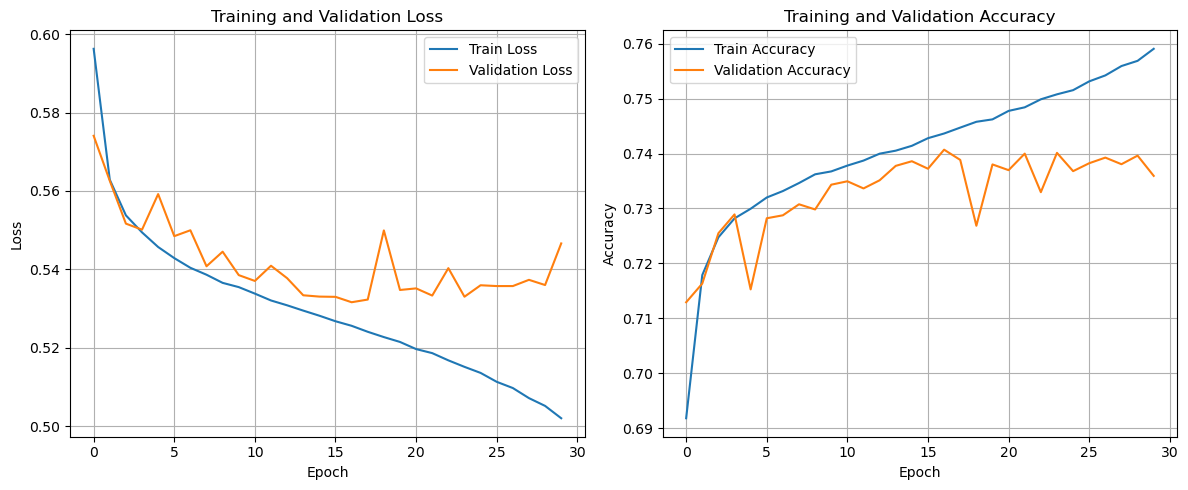

In [9]:
# Plot the training history
plot_history(history)

In [8]:
# Load the checkpoint with the best validation loss
parallel_resnet15.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [17]:
# Train the model with different hyperparameters
lr = 1e-7  # lower learning rate, to see if the model converges
num_epochs = 20
optimizer = optim.Adam(parallel_resnet15.parameters(), lr=lr, eps=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
save_path = '../model-checkpoints/Task1_parallel_resnet15_v2.pt'
history2, parallel_resnet15 = train_and_validate(
    model=parallel_resnet15,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    metric=accuracy_metric_ce,
    scheduler=scheduler,
    num_epochs=num_epochs,
    sep_channels=True,
    save_path=save_path,
    save_strategy='val_loss'  # can be 'val_loss' or 'val_acc'
)

Epoch [1/20], Train Loss: 0.5156, Train Metric: 0.7503, Val Loss: 0.5294, Val Metric: 0.7411
Epoch [2/20], Train Loss: 0.5156, Train Metric: 0.7508, Val Loss: 0.5293, Val Metric: 0.7414
Epoch [3/20], Train Loss: 0.5157, Train Metric: 0.7506, Val Loss: 0.5293, Val Metric: 0.7415
Epoch [4/20], Train Loss: 0.5153, Train Metric: 0.7506, Val Loss: 0.5292, Val Metric: 0.7413
Epoch [5/20], Train Loss: 0.5155, Train Metric: 0.7503, Val Loss: 0.5296, Val Metric: 0.7411
Epoch [6/20], Train Loss: 0.5154, Train Metric: 0.7502, Val Loss: 0.5294, Val Metric: 0.7417
Epoch [7/20], Train Loss: 0.5154, Train Metric: 0.7501, Val Loss: 0.5292, Val Metric: 0.7419
Epoch [8/20], Train Loss: 0.5154, Train Metric: 0.7505, Val Loss: 0.5293, Val Metric: 0.7414
Epoch [9/20], Train Loss: 0.5153, Train Metric: 0.7506, Val Loss: 0.5295, Val Metric: 0.7416
Epoch [10/20], Train Loss: 0.5155, Train Metric: 0.7503, Val Loss: 0.5294, Val Metric: 0.7419
Epoch [11/20], Train Loss: 0.5153, Train Metric: 0.7505, Val Loss: 0.

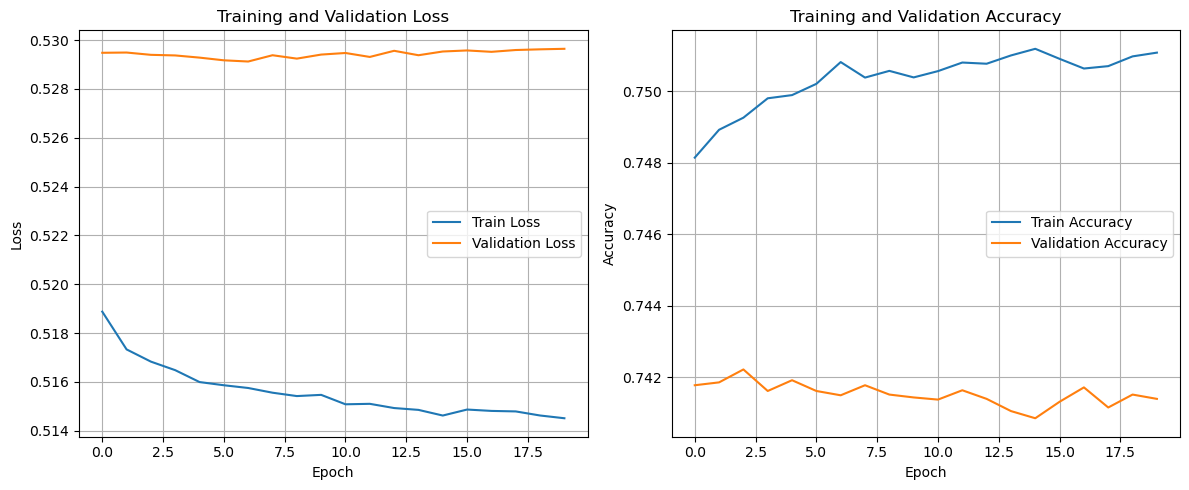

In [12]:
# Plot the second training history
plot_history(history2)

In [9]:
# Load the checkpoint with the best validation loss
parallel_resnet15.load_state_dict(torch.load(save_path))

<All keys matched successfully>

Test Loss: 0.5309, Test Metric: 0.7394, ROC AUC: 0.8109


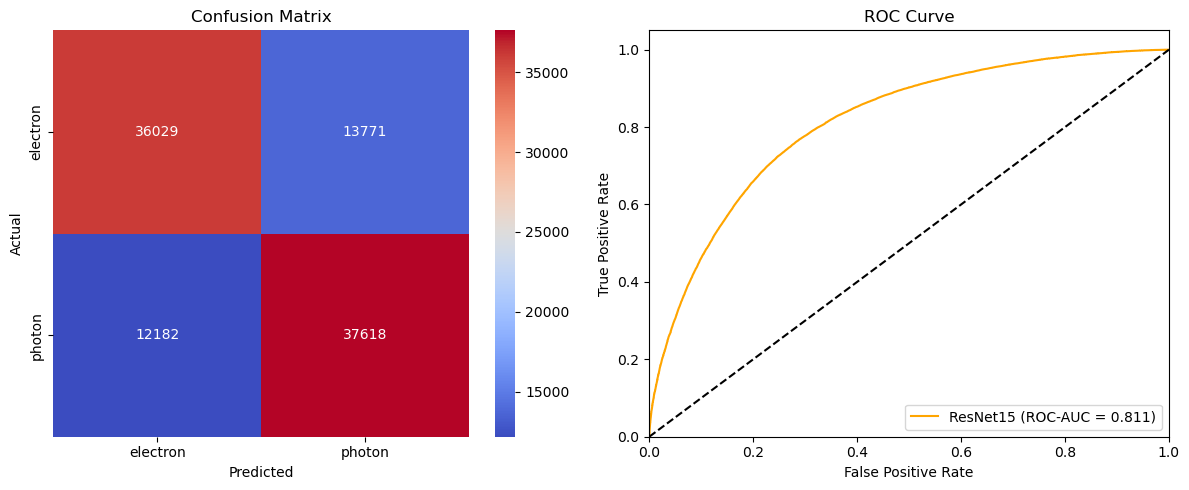

In [10]:
# Evaluate the model
test(
    model=parallel_resnet15,
    test_loader=test_loader,
    criterion=criterion,
    metric=accuracy_metric_ce,
    sep_channels=True,
    loss_type='ce',
    model_name='ResNet15',
    classes=['electron', 'photon']
)